<font size="+3"><strong>7.5. Admissions in the MScFE 🎓🗞</strong></font>

In [31]:
from pymongo import MongoClient
from pymongo.collection import Collection
from pprint import PrettyPrinter
import random
import pandas as pd
import plotly.express as px
from country_converter import CountryConverter

import math
import scipy
import numpy as np
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower

In [2]:
client = MongoClient(host="localhost",port=27017)
db = client["abtest-db"]
mscfe_app = db["mscfe-applicants"]
print("ds_app type:", type(mscfe_app))

ds_app type: <class 'pymongo.synchronous.collection.Collection'>


In [3]:
# Aggregate applicants by nationality
result = mscfe_app.aggregate(
    [
        {
            "$group": {
                "_id": "$countryISO2", "count": { "$count": {}}
            }
        }
    ]
)
print("result type:", type(result))

# Load result into DataFrame
df_nationality = pd.DataFrame(result).rename({"_id": "country_iso2"}, axis="columns").sort_values("count")
print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

result type: <class 'pymongo.synchronous.command_cursor.CommandCursor'>
df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (100, 2)


,country_iso2,count
84,SA,1
85,HT,1
58,TH,1
83,PT,1
57,PE,1


In [4]:
# Instantiate `CountryConverter`
cc = CountryConverter()

# Create `"country_name"` column
df_nationality["country_name"] = cc.convert(
    df_nationality["country_iso2"], to="name_short"
)

# Create `"country_iso3"` column
df_nationality["country_iso3"] = cc.convert(df_nationality["country_iso2"], to="ISO3")

print("df_nationality type:", type(df_nationality))
print("df_nationality shape", df_nationality.shape)
df_nationality.head()

df_nationality type: <class 'pandas.core.frame.DataFrame'>
df_nationality shape (100, 4)


,country_iso2,count,country_name,country_iso3
84,SA,1,Saudi Arabia,SAU
85,HT,1,Haiti,HTI
58,TH,1,Thailand,THA
83,PT,1,Portugal,PRT
57,PE,1,Peru,PER


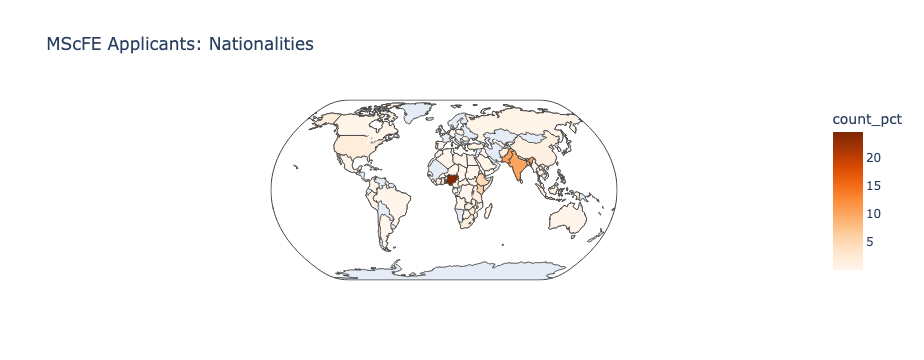

In [6]:
df_nationality["count_pct"] = (
    (df_nationality["count"] / df_nationality["count"].sum()) * 100
)
# Create `build_nat_choropleth` function
def build_nat_choropleth():
    fig = px.choropleth(
        data_frame=df_nationality,
        locations="country_iso3",
        color="count_pct",
        projection="natural earth",
        color_continuous_scale=px.colors.sequential.Oranges,
        title="MScFE Applicants: Nationalities"
    )
    return fig


nat_fig = build_nat_choropleth()
nat_fig.show()

In [46]:
class MongoRepository:
    """Repository class for interacting with MongoDB database.

    Parameters
    ----------
    client : `pymongo.MongoClient`
        By default, `MongoClient(host='localhost', port=27017)`.
    db : str
        By default, `'wqu-abtest'`.
    collection : str
        By default, `'mscfe-applicants'`.

    Attributes
    ----------
    collection : pymongo.collection.Collection
        All data will be extracted from and loaded to this collection.
    """
    def __init__(
        self,
        client=MongoClient(host="localhost",port=27017),
        db="abtest-db",
        collection="mscfe-applicants-after-experiment" #changes before and after experiment
    ):
        self.collection = client[db][collection]

    def find_by_date(self, date_string):
        """Find records in a PyMongo Collection created on a given date.
    
        Parameters
        ----------
        collection : pymongo.collection.Collection
            Collection in which to search for documents.
        date_string : str
            Date to query. Format must be '%Y-%m-%d', e.g. '2022-06-28'.
    
        Returns
        -------
        observations : list
            Result of query. List of documents (dictionaries).
        """
        # Convert `date_string` to datetime object
        start = pd.to_datetime(date_string, format="%Y-%m-%d")
        end = start + pd.DateOffset(days=1)
    
        # Try both string and datetime query to handle both cases
        start_str = start.strftime("%Y-%m-%dT%H:%M:%S")
        end_str = end.strftime("%Y-%m-%dT%H:%M:%S")
    
        # Build OR query to match both possible types
        query = {
            "$and": [
                { "admissionsQuiz": "incomplete" },
                {
                    "$or": [
                        { "createdAt": { "$gte": start, "$lt": end } },        # if createdAt is stored as datetime
                        { "createdAt": { "$gte": start_str, "$lt": end_str } } # if createdAt is stored as string
                    ]
                }
            ]
        }
    
        result = self.collection.find(query)
        observations = list(result)
    
        return observations

    def update_applicants(self, observations_assigned):
        """Update applicant documents in collection.
    
        Parameters
        ----------
        collection : pymongo.collection.Collection
            Collection in which documents will be updated.
    
        observations_assigned : list
            Documents that will be used to update collection
    
        Returns
        -------
        transaction_result : dict
            Status of update operation, including number of documents
            and number of documents modified.
        """
        n =0
        n_modified=0
        
        for doc in observations_assigned: 
            result = self.collection.update_one(
                filter={"_id": doc["_id"]},
                update={"$set": doc}
            )
            n+= result.matched_count
            n_modified+= result.modified_count
        transaction_result = {"n": n, "nModified": n_modified}
        
        return transaction_result

    def assign_to_groups(self,date_string):
        """Randomly assigns observations to control and treatment groups.

        Parameters
        ----------
        observations : list or pymongo.cursor.Cursor
            List of users to assign to groups.

        Returns
        -------
        observations : list
            List of documents from `observations` with two additional keys:
            `inExperiment` and `group`.
        """
        observations = self.find_by_date(date_string)

        # Shuffle `observations`
        random.seed(42)
        random.shuffle(observations)
        # Get index position of item at observations halfway point
        idx = len(observations)//2

        # Assign first half of observations to control group
        for doc in observations[:idx]:
            doc["inExperiment"] = True
            doc["group"] = "no email (control)"

        # Assign second half of observations to treatment group      
        for doc in observations[idx:]:
            doc["inExperiment"] = True
            doc["group"] = "email (treatment)"
        
        result = self.update_applicants(observations);

        return result
    
    def find_exp_observations(self): 
        results= self.collection.find({"inExperiment": True})
        observations = list(results);
        return observations;
    

In [47]:
repo = MongoRepository()
print("repo type:", type(repo))
repo

repo type: <class '__main__.MongoRepository'>


In [48]:
repo.find_by_date("2022-06-01")

[{'_id': '684bf8e20f889962e2a05e23',
  'createdAt': '2022-06-01T22:07:18',
  'firstName': 'Gail',
  'lastName': 'Weaver',
  'email': 'gail.weaver31@hotmeal.com',
  'birthday': '1996-01-10T00:00:00',
  'gender': 'female',
  'highestDegreeEarned': "Master's degree",
  'countryISO2': 'SG',
  'admissionsQuiz': 'incomplete'},
 {'_id': '684bf8e20f889962e2a05e4c',
  'createdAt': '2022-06-01T05:30:35',
  'firstName': 'Clint',
  'lastName': 'Zimmerman',
  'email': 'clint.zimmerman78@hotmeal.com',
  'birthday': '1987-03-11T00:00:00',
  'gender': 'male',
  'highestDegreeEarned': "Master's degree",
  'countryISO2': 'GH',
  'admissionsQuiz': 'incomplete'},
 {'_id': '684bf8e20f889962e2a05e75',
  'createdAt': '2022-06-01T22:20:04',
  'firstName': 'Nicholas',
  'lastName': 'Leon',
  'email': 'nicholas.leon30@gmall.com',
  'birthday': '1962-08-08T00:00:00',
  'gender': 'male',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'PK',
  'admissionsQuiz': 'incomplete'},
 {'_id': '684bf8e20f889

In [23]:
date = "2022-06-02"
repo.assign_to_groups(date)

{'n': 9, 'nModified': 9}

In [24]:
repo.find_by_date(date)

[{'_id': '684bf8e20f889962e2a05e29',
  'createdAt': '2022-06-02T15:53:39',
  'firstName': 'Laura',
  'lastName': 'Monty',
  'email': 'laura.monty7@yahow.com',
  'birthday': '1981-07-04T00:00:00',
  'gender': 'female',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'ZW',
  'admissionsQuiz': 'incomplete',
  'group': 'email (treatment)',
  'inExperiment': True},
 {'_id': '684bf8e20f889962e2a05e4b',
  'createdAt': '2022-06-02T00:14:35',
  'firstName': 'Dennis',
  'lastName': 'Rodriguez',
  'email': 'dennis.rodriguez16@microsift.com',
  'birthday': '2000-11-14T00:00:00',
  'gender': 'male',
  'highestDegreeEarned': 'Some College (1-3 years)',
  'countryISO2': 'NG',
  'admissionsQuiz': 'incomplete',
  'group': 'email (treatment)',
  'inExperiment': True},
 {'_id': '684bf8e20f889962e2a05eed',
  'createdAt': '2022-06-02T02:16:39',
  'firstName': 'Robert',
  'lastName': 'Mulligan',
  'email': 'robert.mulligan28@yahow.com',
  'birthday': '1975-03-16T00:00:00',
  'gender': 'male',

In [27]:
chi_square_power = GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.5,alpha=0.05, power=0.8))

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 32
Total # of applicants needed: 64


In [29]:
# Aggregate no-quiz applicants by sign-up date
result = mscfe_app.aggregate(
    [
        { "$match": {"admissionsQuiz": "incomplete"} },
        {
            "$group": {
                "_id": {
                    "$dateTrunc": {
                        "date": {
                            "$dateFromString": { "dateString": "$createdAt" }
                        },
                        "unit": "day"
                    }
                },
                "count": { "$sum": 1 }
            }
        }
    ]
)

print("result type:", type(result))

# Load result into DataFrame
no_quiz_mscfe = (
    pd.DataFrame(result)
    .rename({"_id": "date", "count": "new_users"}, axis=1)
    .set_index("date")
    .sort_index()
    .squeeze()
)

print("no_quiz type:", type(no_quiz_mscfe))
print("no_quiz shape:", no_quiz_mscfe.shape)
no_quiz_mscfe.head()

result type: <class 'pymongo.synchronous.command_cursor.CommandCursor'>
no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)


date
2022-06-01    20
2022-06-02     9
2022-06-03    12
2022-06-04    15
2022-06-05    11
Name: new_users, dtype: int64

In [30]:
mean = no_quiz_mscfe.describe()["mean"]
std = no_quiz_mscfe.describe()["std"]
print("no_quiz_mscfe mean:", mean)
print("no_quiz_mscfe std:", std)

no_quiz_mscfe mean: 12.133333333333333
no_quiz_mscfe std: 3.170264139254595


In [36]:
exp_days = 7 # iterated to 7 till Probability next cell reached 95% or above
sum_mean = mean * exp_days
sum_std = std * np.sqrt(exp_days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 84.93333333333334
Std of sum: 8.3877305028539


In [37]:
prob_65_or_fewer = scipy.stats.norm.cdf(
    group_size*2,
    loc=sum_mean,
    scale=sum_std
)
prob_65_or_greater = 1 - prob_65_or_fewer

print(
    f"Probability of getting 65+ no_quiz in {exp_days} days:",
    round(prob_65_or_greater, 3),
)

Probability of getting 65+ no_quiz in 7 days: 0.994


Using the group_size you calculated earlier and the code you wrote in the previous task, determine how many days you must run your experiment so that you have a 95% or greater chance of getting a sufficient number of observations. Keep in mind that you want to run your experiment for the fewest number of days possible, and no more.

In [40]:
#RUn Experiment
mscfe_app = db["mscfe-applicants-after-experiment"]

In [44]:
repo.find_exp_observations()

[{'_id': '684bf8e20f889962e2a05e29',
  'createdAt': '2022-06-02T15:53:39',
  'firstName': 'Laura',
  'lastName': 'Monty',
  'email': 'laura.monty7@yahow.com',
  'birthday': '1981-07-04T00:00:00',
  'gender': 'female',
  'highestDegreeEarned': "Bachelor's degree",
  'countryISO2': 'ZW',
  'admissionsQuiz': 'incomplete',
  'group': 'email (treatment)',
  'inExperiment': True},
 {'_id': '684bf8e20f889962e2a05e4b',
  'createdAt': '2022-06-02T00:14:35',
  'firstName': 'Dennis',
  'lastName': 'Rodriguez',
  'email': 'dennis.rodriguez16@microsift.com',
  'birthday': '2000-11-14T00:00:00',
  'gender': 'male',
  'highestDegreeEarned': 'Some College (1-3 years)',
  'countryISO2': 'NG',
  'admissionsQuiz': 'incomplete',
  'group': 'email (treatment)',
  'inExperiment': True},
 {'_id': '684bf8e20f889962e2a05eed',
  'createdAt': '2022-06-02T02:16:39',
  'firstName': 'Robert',
  'lastName': 'Mulligan',
  'email': 'robert.mulligan28@yahow.com',
  'birthday': '1975-03-16T00:00:00',
  'gender': 'male',

In [49]:
result = repo.find_exp_observations()
df = pd.DataFrame(result).dropna()

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (68, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,inExperiment,group
0,684c059c0f889962e2a06306,2025-06-15T18:51:18,Larry,Seal,larry.seal60@yahow.com,2002-07-06T00:00:00,male,Master's degree,IT,complete,True,email (t)
1,684c059c0f889962e2a06307,2025-06-16T02:05:28,Patricia,Sanchez,patricia.sanchez83@yahow.com,2004-02-10T00:00:00,female,Bachelor's degree,ET,complete,True,email (t)
2,684c059c0f889962e2a0630e,2025-06-17T01:21:09,Jessica,Hawkes,jessica.hawkes41@gmall.com,1995-10-11T00:00:00,female,Bachelor's degree,IN,complete,True,email (t)
3,684c059c0f889962e2a0631b,2025-06-14T23:50:46,Regina,Coffey,regina.coffey84@microsift.com,1986-04-06T00:00:00,female,Master's degree,NG,complete,True,email (t)
4,684c059c0f889962e2a0631c,2025-06-19T10:02:36,Reginald,Medina,reginald.medina30@hotmeal.com,1988-09-17T00:00:00,male,Master's degree,IN,complete,True,email (t)


In [50]:
data = pd.crosstab(
    index=df["group"],
    columns=df["admissionsQuiz"],
    normalize=False
)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),7,27
no email (c),1,33


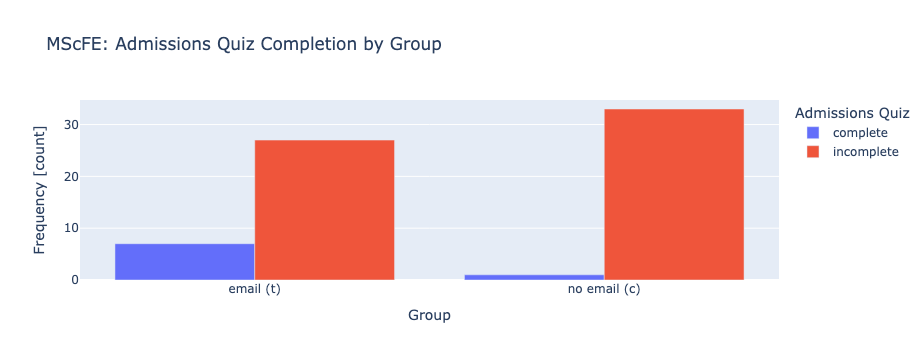

In [51]:
# Create `build_contingency_bar` function
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="MScFE: Admissions Quiz Completion by Group"
    )
    # Set axis labels
    fig.update_layout(
        xaxis_title="Group",
        yaxis_title="Frequency [count]",
        legend={"title": "Admissions Quiz"}
    )
    return fig

cb_fig = build_contingency_bar()

cb_fig.show()

In [52]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[ 7, 27],
       [ 1, 33]])

In [53]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.023925843480626652
statistic   5.1


In [54]:
odds_ratio = contingency_table.oddsratio.round(1)
